In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import random
random.seed(11)

# Introduction:

Thinkful: *Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.*

This large dataset (each file contains about 7 million flights) records basic information about US airline flights such as date, carrier, duration, and predicted and actual arrival and departure times.  It includes scheduled flights that were subsequently cancelled.  Our task is to predict delay amounts.

### Choice 1: Classification vs Regression

There are two fundamental ways to frame this problem.  We could frame it as a <b>classification problem</b>, with delays binned into categories such as:
- early (by at least 15 minutes)
- on time (+/- 15 minutes)
- 15 to 60 minute delay
- 60 to 120 minute delay
- 120+ minute delay
- cancellation

This model would have several advantages: first, it would accord with the categorical definition of lateness given by the US Department of Transportation (USDT).  (In typical fashion, Thinkful has simply got this detail wrong – from the USDT website: "A flight is considered delayed when it arrived 15 or more minutes than the schedule.")  Second, it could provide a fairly high degree of accuracy in its predictions.  Third, it allows cancelled flights to be integrated into the model even though they are non-continuous with delayed flights.  The disadvantages are that it limits the precision of information the model can communicate, and it draws arbitrary category lines between delay intervals, which may diminish its accuracy.

This problem could also be framed as a <b>regression problem</b>: we predict the arrival time of the plane and subtract the scheduled arrival time to give the +/- minutes early or late.  The main disadvantage of this model is that it could not accurately incorporate cancellations, which would need to be removed and/or predicted separately.  However, the regression version of this problem comes with two major advantages.  First, arrival time is inherently a continuous variable, and all other things being equal a model will be better and more accurate if it treats variables according to their actual nature.  Second, it yields the maximum information generated by the model.  Users of a regression model can easily retroactively bin outputs into categories like those listed above; they can't retroactively get minute-amount predictions from a classification model.

Given the nonspecificity of the prompt, and that we don't know for what purpose we're predicting delays, we should err on the side of maximum information.  Therefore <b>we'll proceed with the regression model for now</b>, and potentially take a brief look at a classification version at the end of the notebook.

### Choice 2: prediction in advance, or in-flight

We're also not told here whether we wish to predict delays in advance of the day of a flight, or once a flight is in the air. Several columns (aircraft arrival delay, taxi time out to the runway, departure time) would only be known after or just before takeoff.  We could therefore use them for in-flight delay prediction, but not in-advance prediction.

As it turns out, in-flight delay prediction is almost entirely trivial.  Takeoff delay correlates with arrival delay to a correlation of r^2 = 0.93, so we can predict in-flight delay with a high degree of accuracy before creating any multi-feature model whatsoever.

Instead, we'll focus on in-advance prediction here.  We'll define in advance as knowable before the day takeoff, so we'll be building a model that can predict flight delays by midnight of the previous day.  We will not use any features that could not be known by that time.

### Choice 3: expanding our featureset:

The information here is actually fairly sparse -- especially for predicting flights in advance.  We could actually obtain significantly more data from the data given here.  In particular, we could scrape data from the national weather service for the departure and arrival cities on the date of the flight.  In practice, the weather is known to a high degree of accuracy the day before a flight, so this would be realistic and useful predictive information.  Since weather is one of the main causes of delays, these data points would likely add significant accuracy to this dataset.

It would also be useful to have a measure of air traffic busyness (normalized to median or mean departure/arrival numbers for each airport), since that is a major cause of delays that is also known in advance.  Unlike weather reports, this could be calculated from the dataset itself.

Finally, for in-flight delay prediction, or even just same-day prediction, it would be useful to know how many other flights have been delayed at the arrival and departure airports the day before - this might serve as a metric of bad weather that spans several days.  It may also be useful to know how many flights are delayed at that airport in the previous month (some airports may be less efficient than others).

For this project, we'll proceed with only the information included in this dataset - including air traffic busyness and recent delays at the arrival and departure airports, since those can be extrapolated from existing columns.  This means we won't scrape weather data based on the dates in the dataset - but we'll keep in mind that this would probably be the next step in making these predictions more accurate.

# Load and clean


In [3]:
# raw04_df = pd.read_csv('practice/2004.csv')
# raw05_df = pd.read_csv('practice/2005.csv')
# raw06_df = pd.read_csv('practice/2006.csv')
# raw07_df = pd.read_csv('practice/2007.csv')
raw08_df = pd.read_csv('practice/2008.csv')

KeyboardInterrupt: 

In [84]:
print(raw08_df.shape)
raw08_df.head()

(7009728, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


As described above, for delay prediction we'll only be working on non-cancelled, non-diverted flights.  So our first task - which will eliminate most of our null values (missing arrival times, for instance) – is to drop all cancelled and diverted flights.

In [ ]:
flights08_df = raw08_df[(raw08_df.Cancelled==0) & (raw08_df.Diverted==0)]
flights08_df.shape

Now we'll do some miscellaneous other cleaning:

In [ ]:
# drop the five flights with missing tail numbers:
flights08_df = flights08_df[flights08_df.TailNum.isnull()==False]

# drop cancellation code (they're all null, since we've dropped cancelled flights)
flights08_df.drop('CancellationCode', axis=1, inplace=True)

# for delay columns (minutes delayed for weather, carrier issues, etc):
# - convert nulls to 0 (since no delay is a delay of 0 minutes)
# - convert from string to int
for colname in ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']:
    flights08_df[colname] = flights08_df[colname].fillna(value='0')
    flights08_df[colname] = flights08_df[colname].astype(int)
    
# flight number (currently an int) is actually a categorical variable.  However, two numerical features are meaningful:
# odd-vs-even traditionally indicates East/North - vs - South/West bound flights:
flights08_df['flNumOdd'] = flights08_df.FlightNum%2
# number of digits indicates premium vs regional flight, which is a categorical difference 
# (and we'll convert to string first to make FlightNum categorical)
flights08_df['FlightNum'] = flights08_df.FlightNum.astype(str)
flights08_df['flNumDigitCount'] = flights08_df.FlightNum.str.len().astype(str)

# we'll need scheduled departure date as a Datetime object for later feature generation:
# hour = flights08_df.CRSDepTime.astype(int).astype(str).str.slice(stop=-2)
# minute = flights08_df.CRSDepTime.astype(int).astype(str).str.slice(start=-2)
# flights08_df['dTime'] = pd.to_datetime({'year':flights08_df.Year, 'month':flights08_df.Month, 'day':flights08_df.DayofMonth, 'hour':hour, 'minute':minute})
flights08_df['dDate'] = pd.to_datetime({'year':flights08_df.Year, 'month':flights08_df.Month, 'day':flights08_df.DayofMonth})

# times are formatted as hhmm integers, meaning that hours are represented as being a hundred minutes long.
# we'll convert these to hour of the day, with decimals representing decimals of a whole hour (not minutes)
time_cols = ['DepTime', 'CRSDepTime','ArrTime', 'CRSArrTime']
for colname in time_cols:
    # hour-in-day = hours + minutes/60
    flights08_df[colname] = (flights08_df.CRSDepTime//100) + (flights08_df.CRSDepTime%100) / 60
    flights08_df[colname] = flights08_df[colname].round(1)
# all our numerical columns are stored as floats but should be ints - they're all whole numbers written as x.0
for colname in flights08_df.columns:
    if flights08_df[colname].dtype == float and colname not in time_cols:
        flights08_df[colname] = flights08_df[colname].astype(int)
        
# distance (miles) and CRSElapsedTime (scheduled air time) have a 0.98 correlation; we'll drop distance
flights08_df.drop('Distance', axis=1, inplace=True)

### Engineered features

Now we'll engineer the features discussed in the introduction:
- <b>depTraffic</b>: departure traffic (as a percentage of the airport's average daily traffic) at origin airport
- <b>arrTraffic</b>: arrival traffic (as a percentage of the airport's average daily traffic) at destination airport
- <b>avDepDelay</b>: average delay (minutes) for planes taking off from origin airport during the previous day
- <b>avArrDelay</b>: average delay (minutes) for planes arriving at the destination airport during the previous day

In [362]:
from time import time
start = time()

# CREATE a column containing the departure traffic (as a percentage of average departure traffic) of the origin airport
# average dept traffic = average arr traffic over the course of the year, so one column will do for both
# (technically, we wouldn't know all of this, but it doesn't give any major advantave and could be done on prev year)
av_traffic = flights08_df.groupby(['Origin']).DayofMonth.agg('count')/365
# get departures scheduled from each airport on each date
date_departures = flights08_df.groupby(['dDate', 'Origin']).DayofMonth.agg('count')
# set arrival traffic = 100 * scheduled departures / av departures for the origin airport of each flight
flights08_df['arrTraffic'] = flights08_df.apply(lambda row: round(100*date_departures[row['dDate']][row['Origin']] / av_traffic[row['Origin']]),
                            axis=1)

# CREATE a column containing the arrival traffic (as a percentage average arrival traffic) of the origin airport
date_arrivals = flights08_df.groupby(['dDate', 'Dest']).DayofMonth.agg('count')
flights08_df['depTraffic'] = flights08_df.apply(lambda row: round(100*date_arrivals[row['dDate']][row['Dest']] / av_traffic[row['Dest']]),
                            axis=1)
time()-start

9006.477833032608

In [382]:
from datetime import timedelta, datetime

def avDelayBefore(row, airport):
    ''' Airport: str, either 'Origin' or 'Destination'  '''
    day_before = row['dDate'] - timedelta(hours=24)
    if row['dDate'] == datetime(2008, 1, 1):
        # for Jan 1, we have no day before to work with because of the artificial bound of this dataset.  
        # We'll drop Jan 1 flights after this operation.
        av = 0
    else:
        if row[airport] in av_dep_delay[day_before]:
            av = av_dep_delay[day_before][row[airport]]
        # if there are no flights the day before, check two days before
        elif row['dDate'] > datetime(2008, 1, 2) and row[airport] in av_dep_delay[day_before - timedelta(hours=24)]:
            av = av_dep_delay[day_before - timedelta(hours=24)][row[airport]]
        else:
            # If there weren't any flights that day or the day before (very rare - .07% of cases), set av flights = 0
            av = 0
    return av
    
start = time()

# CREATE a column containing the average departure delay at the origin airport over the previous day
av_dep_delay = flights08_df.groupby(['dDate','Origin']).DepDelay.agg(np.mean)
print('starting first apply function at', str(time()-start), 'seconds...')
flights08_df['avDepDelay'] = flights08_df.apply(lambda row: avDelayBefore(row, 'Origin'),axis=1)

# CREATE a column containing the average arrival delay at the destination airport over the previous month
av_arr_delay = flights08_df.groupby(['dDate','Dest']).ArrDelay.agg(np.mean)
print('starting second apply function at', str(time()-start), 'seconds...')
flights08_df['avArrDelay'] = flights08_df.apply(lambda row: avDelayBefore(row, 'Dest'),axis=1)

time()-start

starting first apply function at 1.4027032852172852 seconds...
starting second apply function...  6587.221023082733  seconds...


12821.109941005707

In [383]:
# save dataset with engineered features in case of reload
flights08_df.to_csv('engineered.csv')

In [4]:
from datetime import datetime
from time import time
flights08_df = pd.read_csv('engineered.csv', index_col=0)

/usr/local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
# drop Jan 1 flights because they couldn't yield a day-before-based value
nyears_flights_df = flights08_df[flights08_df['dDate'] == datetime(2008, 1, 1)]
flights08_df = flights08_df[flights08_df['dDate'] != datetime(2008, 1, 1)]

Now let's drop all the columns that we wouldn't know a day in advance, except for our target column of ArrDelay.

In [6]:
dropcols = ['ArrTime',
            'ActualElapsedTime',
            'AirTime',
            'DepDelay',
            'DepDelay',
            'TaxiIn',
            'TaxiOut',
            'Cancelled',
            'Diverted',
            'CarrierDelay',
            'WeatherDelay',
            'NASDelay',
            'SecurityDelay',
            'LateAircraftDelay']
flights08_df.drop(dropcols, axis=1, inplace=True)

In [5]:
round(flights08_df.describe(), 1)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,flNumOdd,flNumDigitCount,arrTraffic,depTraffic,avDepDelay,avArrDelay
count,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0,6855024.0
mean,2008.0,6.4,15.7,3.9,13.4,13.4,0.2,2212.5,129.1,8.2,0.5,3.6,101.6,101.6,10.0,10.0
std,0.0,3.4,8.8,2.0,4.7,4.7,0.1,1956.4,69.5,38.5,0.5,0.6,19.4,16.8,12.7,12.7
min,2008.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-141.0,-519.0,0.0,1.0,0.0,0.0,-40.0,-40.0
25%,2008.0,3.0,8.0,2.0,9.4,9.4,0.2,618.0,80.0,-10.0,0.0,3.0,95.0,95.0,2.7,2.7
50%,2008.0,6.0,16.0,4.0,13.3,13.3,0.2,1563.0,111.0,-2.0,0.0,4.0,103.0,103.0,6.8,6.8
75%,2008.0,9.0,23.0,6.0,17.2,17.2,0.3,3494.0,159.0,12.0,1.0,4.0,108.0,108.0,13.0,13.0
max,2008.0,12.0,31.0,7.0,24.0,24.0,0.4,9741.0,660.0,2461.0,1.0,4.0,18250.0,7300.0,993.0,738.0


It looks like we've got a few erroneous outliers in the delay times.  It's pretty safe to say that no flight had a scheduled airtime of negative minutes, or legitimately arrived eight and a half hours early, so we'll drop those.

(Note: even if some of 28 flights dropped here were to be legitimate outliers, they collectively represent 0.0004% of our datset.)

In [7]:
# we'll drop the 17 flights with scheduled airtimes of less than fifteen minutes 
# (including 10 with negative airtime!) as erroneous
flights08_df = flights08_df[flights08_df.CRSElapsedTime > 15]

# we'll also drop the one flight that supposedly arrived 8.5 hours early (the only flight over 2h10m early)
flights08_df = flights08_df[flights08_df.ArrDelay > -500]

# finally, we'll drop the ten flights that were supposedly delayed more than 24 hours (rather than cancelled)
flights08_df = flights08_df[flights08_df.ArrDelay < 60*24]

# Examining the data

In [9]:
round(flights08_df.describe(), 1)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,flNumOdd,flNumDigitCount,arrTraffic,depTraffic,avDepDelay,avArrDelay
count,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0,6854963.0
mean,2008.0,6.4,15.7,3.9,13.4,13.4,0.2,2212.5,129.1,8.2,0.5,3.6,101.6,101.6,10.0,10.0
std,0.0,3.4,8.8,2.0,4.7,4.7,0.1,1956.4,69.5,38.4,0.5,0.6,16.7,16.8,12.7,12.7
min,2008.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,16.0,-129.0,0.0,1.0,0.0,0.0,-40.0,-40.0
25%,2008.0,3.0,8.0,2.0,9.4,9.4,0.2,618.0,80.0,-10.0,0.0,3.0,95.0,95.0,2.7,2.7
50%,2008.0,6.0,16.0,4.0,13.3,13.3,0.2,1563.0,111.0,-2.0,0.0,4.0,103.0,103.0,6.8,6.8
75%,2008.0,9.0,23.0,6.0,17.2,17.2,0.3,3494.0,159.0,12.0,1.0,4.0,108.0,108.0,13.0,13.0
max,2008.0,12.0,31.0,7.0,24.0,24.0,0.4,9741.0,660.0,1417.0,1.0,4.0,7300.0,7300.0,993.0,738.0


A few highlights here:
- Average departure time is about 1:00 PM
- Average scheduled flight duration is about two hours
- Average arrival delay is eight minutes late, but the typical (median) arrival is two minutes early

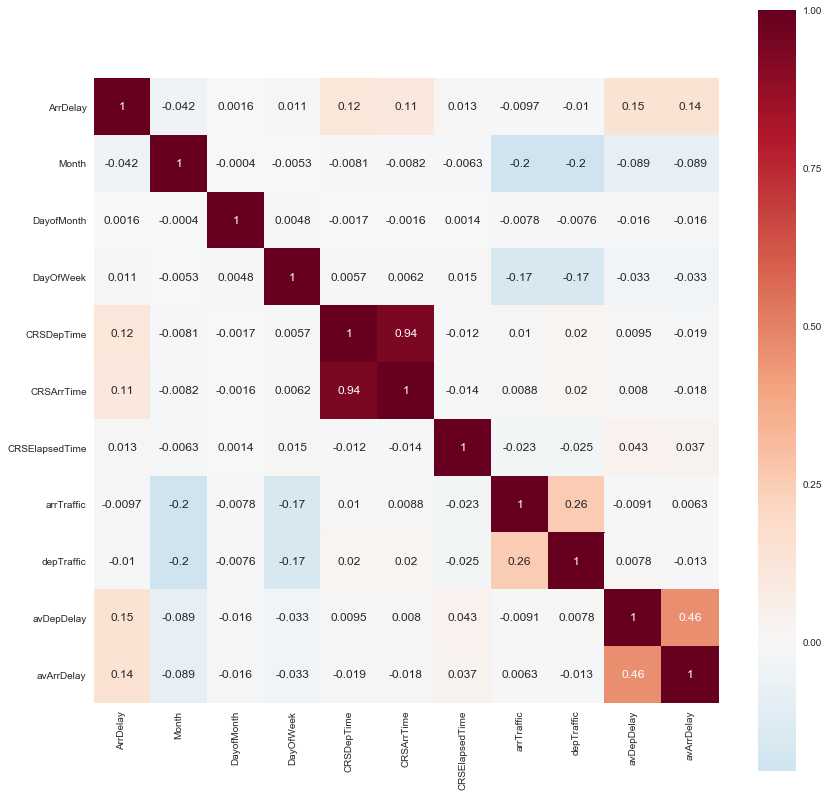

In [477]:
corrCols = ['ArrDelay','Month', 'DayofMonth','DayOfWeek','CRSDepTime','CRSArrTime','CRSElapsedTime','arrTraffic','depTraffic','avDepDelay', 'avArrDelay']
plt.figure(figsize=(14,14))
sns.heatmap(flights08_df[corrCols].corr(), square=True, annot=True, center=0, cmap='RdBu_r')
plt.show()

Some highlights from this heatmap:
#### Feature Correlations
- Scheduled arrival and departure time have a 0.94 correlation (no surprise there).  We'll drop scheduled arrival time in the next frame.
- depTraffic (departure traffic from origin airport) and arrTraffic (arrivals traffic at destination airport) have a low but significant correlation at r = 0.22.  Often busy travel seasons are busy everywhere.
- depTraffic and arrTraffic have a surprisingly low correlation with arrDelay.  It doesn't look like scheduled busyness of the airport has much to do with flight delays.
- avDepDelay (average departure delay at origin airport on the previous day) and avArrDelay (average arrival delays at the destination airport on the previous day) have a medium-high correlation of r=0.46.  This is at least partly explained by weather patterns at departure and arrival airports being strongly correlated.

#### Target Correlations
- Of pre-existing features, the feature most predictive of delay is scheduled departure time.  This makes sense: morning flights don't face delays because of arriving traffic; later flights do. 
- Of all features, the features most predictive of delay are our engineered features avDepDelay and avArrDelay.  

In [7]:
# dropping scheduled arrival time as discussed above (it's redundant with scheduled departure time)
flights08_df.drop('CRSArrTime', axis=1, inplace=True)

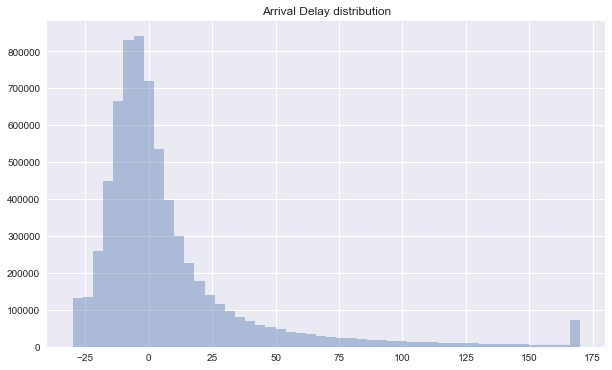

In [483]:
from scipy.stats.mstats import winsorize
plt.figure(figsize=(10,6))
delays = winsorize(flights08_df.ArrDelay.values, limits=(.01))
sns.distplot(delays, kde=False)
plt.title('Arrival Delay distribution')
plt.show()

We can see that our arrival delays have a fairly normal distribution with a long rightward tail.  (The bump at the end of the tail and the sudden drop on the left are due to the 1% winsorization of this plot.)

In [11]:
small_df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'CRSElapsedTime',
       'ArrDelay', 'Origin', 'Dest', 'flNumOdd', 'flNumDigitCount', 'dDate',
       'arrTraffic', 'depTraffic', 'avDepDelay', 'avArrDelay'],
      dtype='object')

It might also be helpful to look at the characteristics of airports, particularly their size (defined by flights per year) and their average flight delay.

In [46]:
airports_df = flights08_df[['Origin', 'ArrDelay']].groupby('Origin').agg(['count', 'mean'])
airports_df.columns = ['_'.join(col).strip() for col in airports_df.columns.values]

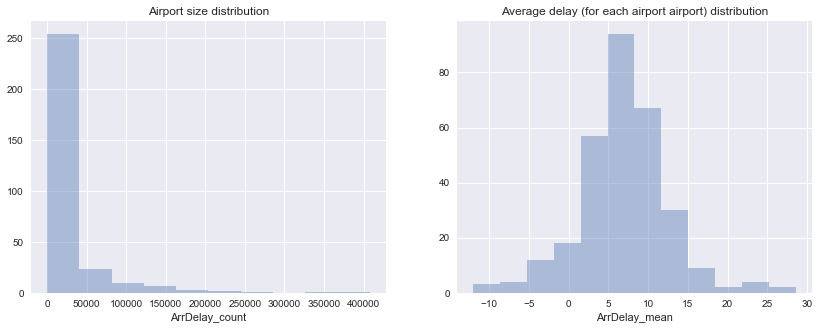

In [47]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.distplot(airports_df.ArrDelay_count, kde=False, bins=10)
plt.title("Airport size distribution")
plt.subplot(1,2,2)
sns.distplot(airports_df.ArrDelay_mean, kde=False, bins=12)
plt.title("Average delay (for each airport airport) distribution")
plt.show()

In [48]:
def tierLabel(traffic):
    if traffic < 10000:
        return 'tiny'
    elif traffic < 40000:
        return 'small'
    elif traffic < 100000:
        return 'midsize'
    elif traffic < 250000:
        return 'large'
    else:
        return 'huge'
airports_df['Size'] = [tierLabel(count) for count in airports_df.ArrDelay_count]

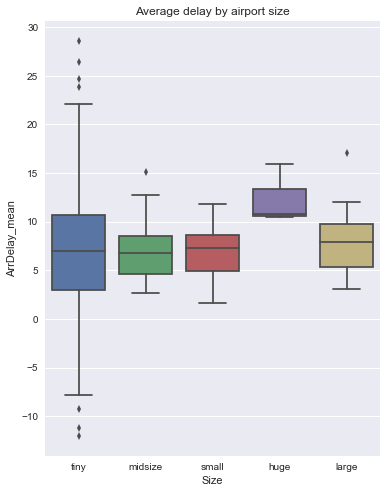

In [56]:
plt.figure(figsize=(6,8))
sns.boxplot(x=airports_df.Size, y=airports_df.ArrDelay_mean)
plt.title('Average delay by airport size')
plt.show()

This is interesting.  Unsurprisingly, the smallest airports exhibit high variability in average delays from airport to airport, centering around the same median as other size classes of airports.  What's quite surprising is that the 17 airports defined here as 'large' - i.e., having more than 100K but fewer than 250K flights per year - exhibit much higher delay times across the board.  The three 'huge' airports have slightly higher percentiles than the others, but only barely.

This is a clear example of non-linearity in the dataset: size of the airport does matter, but not in a linear direction.  This suggests that non-linear models such as SVR or tree-based models will be more effective than linear-based models like logistic regression.

# Initial modeling

### Splitting data

In [8]:
from sklearn.model_selection import train_test_split
X = flights08_df.drop(['dDate','ArrDelay'], axis=1)
y = flights08_df.ArrDelay
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Some models can't accept categorical variables.  For these, we'll create a quantitative-only version.
# The values are too numerous to split into dummy variables without enormous computational cost
# except for UniqueCarrier, which has 20 values and may be worth dummying
X_quant_train = X_train.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)
X_quant_test = X_test.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)
X_quantdum_train = pd.get_dummies(X_train.drop(['TailNum','Origin','Dest'], axis=1))
X_quantdum_test = pd.get_dummies(X_test.drop(['TailNum','Origin','Dest'], axis=1))

# NOTE: binary encoding would probably be better here, and would make encoding airports feasible with size-binning
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html
# BETTER STILL would be clustering the airports by multiple features (traffic, av delay, etc) 
# and categorizing accordingly

### Linear SGD Regression

In [9]:
from sklearn.linear_model import SGDRegressor
start = time()
lasso = SGDRegressor(penalty='l1', alpha=0.1, max_iter=100)
lasso.fit(X_quant_train, y_train)
score = lasso.score(X_quant_test, y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: -1.608416082453562e+26
Elapsed time: 211 seconds


In [10]:
start = time()
lasso = SGDRegressor(penalty='l1', alpha=0.01, max_iter=100)
lasso.fit(X_quantdum_train, y_train)
score = lasso.score(X_quantdum_test, y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: -2.426426731376579e+25
Elapsed time: 270 seconds


This is very puzzling: there's a 0.14 and 0.15 correlation between two of our features and our target feature, yet linear regression can only come up with an R^2 of 0?  This should be theoretically impossible: in the worst-case scenario, Lasso regression should zero out all the other coefficients and come up with an R^2 of at least 0.04 from those two alone.  (I tried this with all sorts of alpha values, with little difference in results).

If we manually eliminate all but those the single most correlative feature (avArrDelay; r=0.15):

In [11]:
start = time()
lasso = SGDRegressor(penalty='l1', alpha=.002, max_iter=50)
lasso.fit(X_quant_train[['avArrDelay']], y_train)
score = lasso.score(X_quant_test[['avArrDelay']], y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.01635816179934846
Elapsed time: 51 seconds


Something is going wrong here.  For one thing, this score still only gets to 0.015, when we should get 0.0225 (0.15^2).  More fundamentally, *this shouldn't improve our score at all*.  Lasso should do this sort of feature elimination for us; the results of running just the top feature should be the absolute worst-case output of Lasso.

I have no idea what's going on here.

Let's see if Ridge does any better for us:

In [12]:
start = time()
lasso = SGDRegressor(penalty='l2', alpha=1, max_iter=50)
lasso.fit(X_quant_train[['avArrDelay']], y_train)
score = lasso.score(X_quant_test[['avArrDelay']], y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.005046258845614382
Elapsed time: 56 seconds


In [13]:
start = time()
lasso = SGDRegressor(penalty='l2', alpha=10, max_iter=50)
lasso.fit(X_quant_train[['avArrDelay']], y_train)
score = lasso.score(X_quant_test[['avArrDelay']], y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.01913775348052693
Elapsed time: 48 seconds


In [16]:
start = time()
lasso = SGDRegressor(penalty='l2', alpha=.01, max_iter=50)
lasso.fit(X_quant_train[['avArrDelay']], y_train)
score = lasso.score(X_quant_test[['avArrDelay']], y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.009599740743151175
Elapsed time: 53 seconds


We do in fact get somewhat better results with Ridge, though still lower than we ought to expect.  

For now, let's move on to less linearly-constrained models.

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
start = time()
rfr = RandomForestRegressor()
rfr.fit(X_quant_train, y_train),
score = rfr.score(X_quant_test, y_test)
print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

Score: 0.18109405683563895
Elapsed time: 830 seconds


This is better, but still a surprisingly low score.  It probably doesn't help that we're losing several important quantitative variables here because of sklearn's inability to handle them in trees (even though trees can handle them directly in some implementations).  But it still – literally and figuratively – doesn't add up.

We might be able to achieve a higher score by adding back in more encoded categorical features and/or running a parameter sweep - but those of these would hugely increase our computation cost, which is already considerable.

### SVR Kernel Approximation

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

start = time()

rbf_approx = RBFSampler(gamma=1, random_state=1)
X_rbf_train = rbf_approx.fit_transform(X_quant_train)
X_rbf_test = rbf_approx.transform(X_quant_test)
clf = SGDClassifier(max_iter=50)   
clf.fit(X_rbf_train, y_train)
score = clf.score(X_rbf_test, y_test)

print("Score:", score)
print("Elapsed time:", round(time()-start), "seconds")

NOTE: gave up on this after waiting for 2 hours

# Conclusions (for now)

Despite the poor results so far, I'm happy with my feature engineering in this project.  It took a lot of debugging and optimizing, but I successfully produced the most predictive features in the entire dataset (and learned a lot about dataframe operations and optimizations along the way).  These are likely to be very helpful with the right algorithm.

There are three factors preventing effective prediction here: 
- the size of the dataset (with my limited processing power)
- the several important categorical variables 
- the non-linearity of the correlations
This problem is likely to be highly non-linear, demanding a non-linear model.  But non-linear classifiers are computationally expensive.  Add in a large dataset that would become much larger still if the categorical features were one-hot encoded (or even binary-encoded), and you've got a real problem.

That said, I can see three likely routes to success from here:
- <b>SVR kernel approximation + more time:</b>  I may be able to be reasonably successful with a SVR kernel approximation if I reduce n_components and let it run overnight.  Especially effective with GLRM (below) to include the categorical features.
- <b>GLRM:</b> GLRM would allow me to use my categorical variables while reducing (rather than ballooning) my featureset and thus cutting computation time significantly.  This would be especially effective in combination with XGBoost, but even sklearn's random forest and boosted tree might become computationally manageable and reasonably accurate.
- <b>H2O Random forest / gradient boost regression:</b> H2O is generally much faster than sklearn for large datasets, and even more importantly, it handles categorical variables directly (it's a bit frustrating that sklearn can't do this).  This can capture non-linear correlations and inter-feature relationships.
- <b>Neural Nets:</b> These are made to handle complex non-linear prediction, and there's cloud GPU computing available to handle the computational cost.

I may try the SVR approximation on my own.  However, the other avenues all require other external tasks: notably installing and learning H2O, manually installing XGBoost, and getting up to speed on Neural Nets.  Since all of these are on my agenda soon, I'm going to table this project for now.  I hope to return to it later when I'm equipped with the tools I need.

*Note: the complete model should include cancellation/diversion classification, then delay prediction for non-cancelled flights.*